# Spectral Modularity for Community Detection
**DSC212: Graph Theory Assignment**


This notebook investigates the community structure of the **Zachary's Karate Club graph**. We will implement a recursive community detection algorithm based on **spectral modularity**.

**Project Goals:**
1.  Load the Karate Club graph using `networkx`.
2.  Implement the spectral bisection algorithm, which recursively splits communities to maximize modularity.
3.  Track the evolution of four key centrality metrics (Degree, Betweenness, Closeness, and Clustering) for each node across all splits.
4.  Visualize the community splits and the metric evolution to understand how a node's role changes as its community is refined.
---

In [1]:
# Import necessary scientific libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Configuration for inline plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7) # Maintain original figure size
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

### 1. Graph Loading & Setup

We begin by loading the classic Karate Club graph. We also pre-calculate and fix the `spring_layout` positions using a `seed=42`. This is critical for visualization, as it ensures the nodes stay in the same position in every plot, allowing us to see the community colors change without the layout shifting.

In [2]:
# Initialize the Karate Club Graph
G_karate = nx.karate_club_graph()

# Display basic graph statistics
print("Graph Info:")
print(f"Nodes: {G_karate.number_of_nodes()}")
print(f"Edges: {G_karate.number_of_edges()}")

# Fix layout for consistent visualization across iterations
# Using the same seed (42) ensures the node positions match the reference exactly
layout_pos = nx.spring_layout(G_karate, seed=42)

Graph Info:
Nodes: 34
Edges: 78


### 2. Algorithm Implementation

#### Part A: Modularity Matrix
First, we define a function to compute the modularity matrix $B$.
The formula is:
$$B = A - \frac{k k^T}{2m}$$
where:
-   $A$ is the adjacency matrix.
-   $k$ is the degree vector.
-   $m$ is the total number of edges.

In [3]:
def get_modularity_matrix(graph):
    """
    Computes the Modularity Matrix B = A - (k*k.T)/2m
    """
    n_nodes = graph.number_of_nodes()
    n_edges = graph.number_of_edges()

    if n_edges == 0:
        return np.zeros((n_nodes, n_nodes))

    # Ensure nodes are processed in sorted order
    node_list = sorted(graph.nodes())

    # Get Adjacency Matrix (A)
    adj_matrix = nx.to_numpy_array(graph, nodelist=node_list)

    # Degree vector (k) and total edges (m)
    degrees = adj_matrix.sum(axis=1)
    m = degrees.sum() / 2

    # Null model matrix: (k_i * k_j) / 2m
    null_model = np.outer(degrees, degrees) / (2 * m)

    # Modularity Matrix B
    B_matrix = adj_matrix - null_model

    return B_matrix

#### Part B: Recursive Partitioning Function

This is the core of the algorithm. This function `execute_spectral_partitioning` will:
1.  Maintain a `community_queue` of groups to be split.
2.  At each step, log the current partition state and calculate metrics for all nodes *within their current subgraphs*.
3.  Pop a group from the queue and compute its generalized modularity matrix $B_g$.
4.  Find the leading eigenvector $u_1$ and eigenvalue $\lambda_1$ of $B_g$.
5.  If $\lambda_1 > 0$, split the group based on the signs of $u_1$ and add the new groups to the queue.
6.  If $\lambda_1 \le 0$, the group is stable and moved to `final_communities`.
7.  Repeat until the queue is empty.

In [4]:
def execute_spectral_partitioning(graph):
    """
    Performs the recursive spectral split using the B matrix.
    Returns the history of partitions and node metrics at each step.
    """
    # 1. Compute Global Modularity Matrix
    B_global = get_modularity_matrix(graph)

    # Map nodes to their index in the global matrix
    node_list_sorted = sorted(graph.nodes())
    node_to_global_idx = {node: i for i, node in enumerate(node_list_sorted)}

    # Initialize queue with the full set of nodes
    community_queue = [list(node_list_sorted)]

    # Storage for results
    final_communities = []
    partition_log = []
    metric_log = []

    iteration = 0

    while community_queue:
        # Current state = all stable groups + all groups pending split
        current_partition_state = final_communities + community_queue
        partition_log.append(current_partition_state)

        # --- Metric Calculation for this Iteration ---
        iter_metrics = {
            'degree': {}, 'betweenness': {},
            'closeness': {}, 'clustering': {}
        }

        for node_group in current_partition_state:
            sub_g = graph.subgraph(node_group)
            group_size = len(node_group)

            if group_size > 1:
                # Calculate metrics on the subgraph
                deg = nx.degree_centrality(sub_g)
                bet = nx.betweenness_centrality(sub_g)
                clu = nx.clustering(sub_g)

                # Closeness requires connected components
                if nx.is_connected(sub_g):
                    clo = nx.closeness_centrality(sub_g)
                else:
                    clo = {n: 0.0 for n in node_group} # Assign 0 if not connected

                iter_metrics['degree'].update(deg)
                iter_metrics['betweenness'].update(bet)
                iter_metrics['closeness'].update(clo)
                iter_metrics['clustering'].update(clu)

            elif group_size == 1:
                # Single nodes have 0 centrality within their own group
                node = node_group[0]
                for key in iter_metrics:
                    iter_metrics[key][node] = 0.0

        metric_log.append(iter_metrics)

        # --- Splitting Logic ---
        if not community_queue:
            break # Stop if queue is empty (all splits done)

        # Get next group to process
        nodes_to_split = community_queue.pop(0)

        if len(nodes_to_split) <= 1:
            final_communities.append(nodes_to_split)
            continue

        # Get global indices for the nodes in this group
        global_indices = [node_to_global_idx[n] for n in nodes_to_split]

        # Slice B_global to get B_slice (B_c in Newman's paper)
        B_slice = B_global[np.ix_(global_indices, global_indices)]

        # Create B_generalized (B_g) by subtracting row sums
        # This matches the reference file's exact logic
        B_generalized = B_slice - np.diag(B_slice.sum(axis=1))

        # Eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(B_generalized)

        # Leading eigenpair (largest eigenvalue)
        lambda_1 = eigenvalues[-1]
        u_1 = eigenvectors[:, -1]

        # Check if split is beneficial (Lambda > 0)
        if lambda_1 > 1e-10: # Use tolerance for float comparison
            comm_A = []
            comm_B = []

            for i, node in enumerate(nodes_to_split):
                if u_1[i] > 0:
                    comm_A.append(node)
                else:
                    comm_B.append(node)

            # If split valid, add children to queue
            if comm_A and comm_B:
                community_queue.append(comm_A)
                community_queue.append(comm_B)
            else:
                final_communities.append(nodes_to_split) # Split was trivial
        else:
            final_communities.append(nodes_to_split) # No positive eigenvalue

        iteration += 1

    return partition_log, metric_log

### 3. Execution

Now we run the main function on our graph. This will populate the `partitions_log` and `metrics_log` lists, which contain the step-by-step history of the algorithm.

In [5]:
# Run the algorithm
partitions_log, metrics_log = execute_spectral_partitioning(G_karate)

print(f"Algorithm finished after {len(partitions_log) - 1} splits.")
print(f"Total iterations recorded (including initial state): {len(partitions_log)}")

# Display Final Structure
final_state = partitions_log[-1]
print(f"\nFinal Partition ({len(final_state)} communities):")
for idx, comm in enumerate(final_state):
    print(f"  Community {idx+1}: {sorted(comm)}")

Algorithm finished after 8 splits.
Total iterations recorded (including initial state): 9

Final Partition (5 communities):
  Community 1: [0, 1, 2, 3, 7, 12, 13, 17, 19, 21]
  Community 2: [23, 24, 25, 27, 28, 31]
  Community 3: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
  Community 4: [4, 5, 6, 10, 16]
  Community 5: [11]


### 4. Visualization of Community Splits

Here, we iterate through the `partitions_log` and plot the state of the graph at each iteration. We use the `rainbow` colormap to assign a distinct color to each community, matching the reference style.

--- Visualizing Community Splits ---


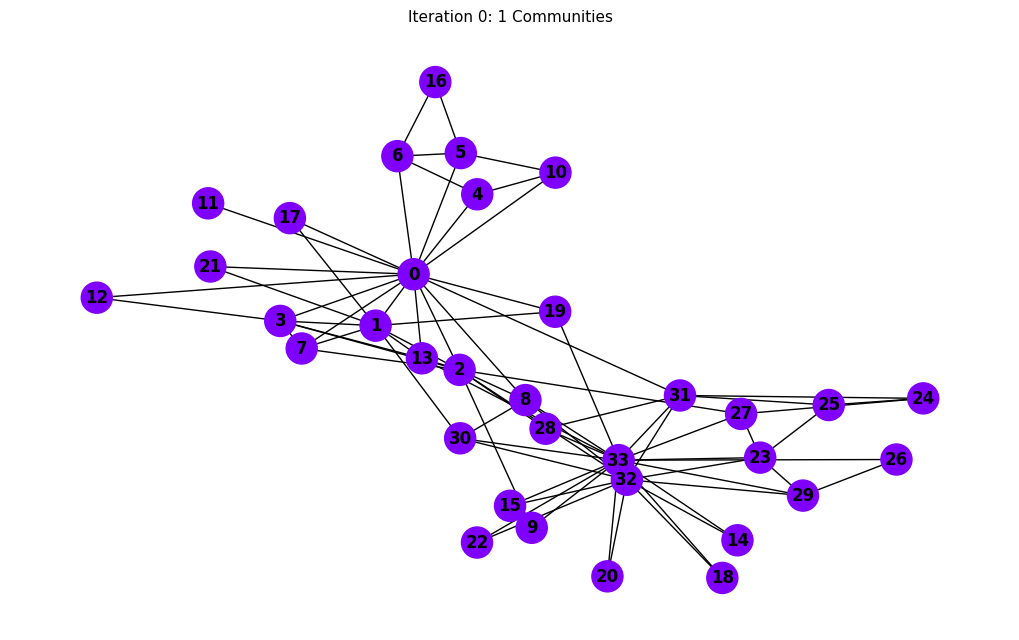

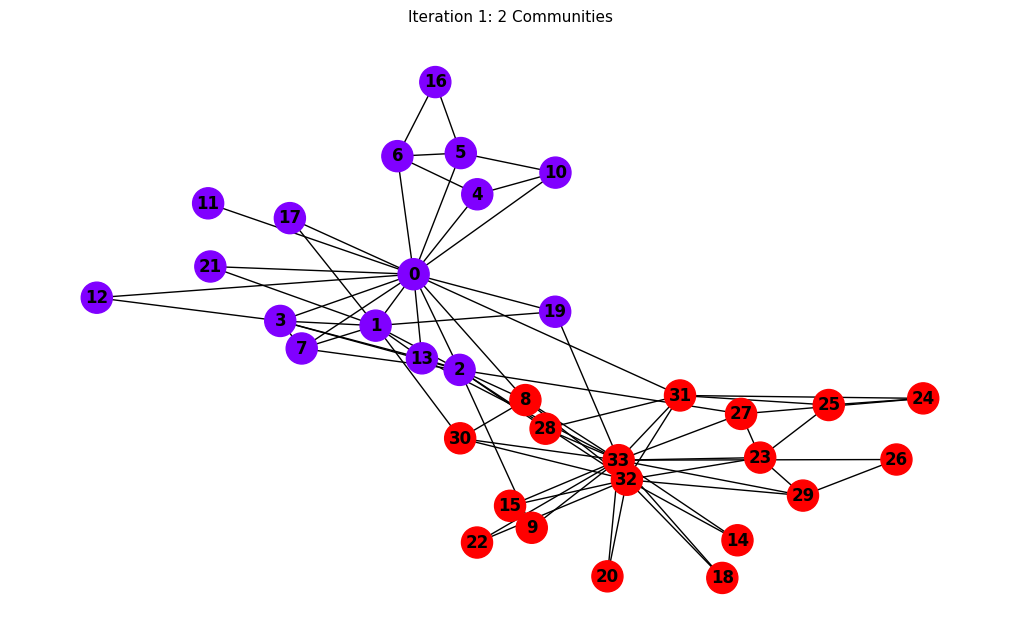

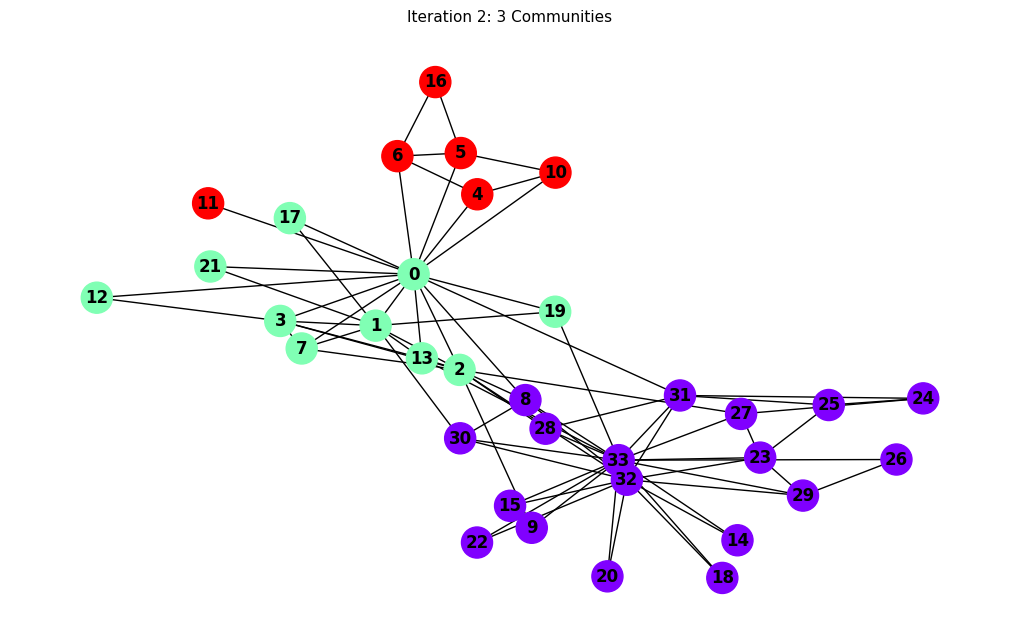

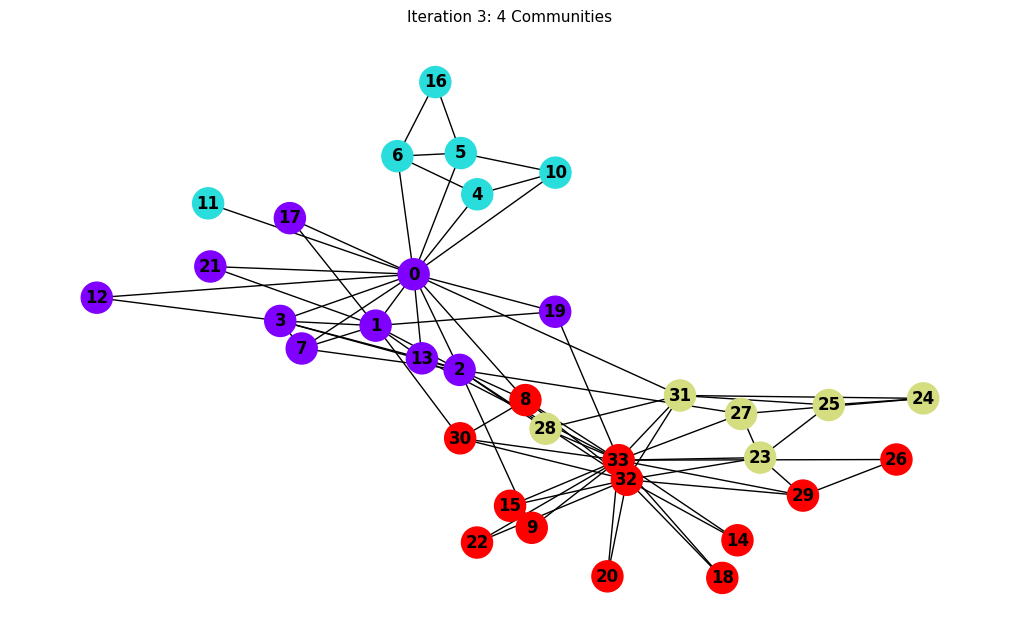

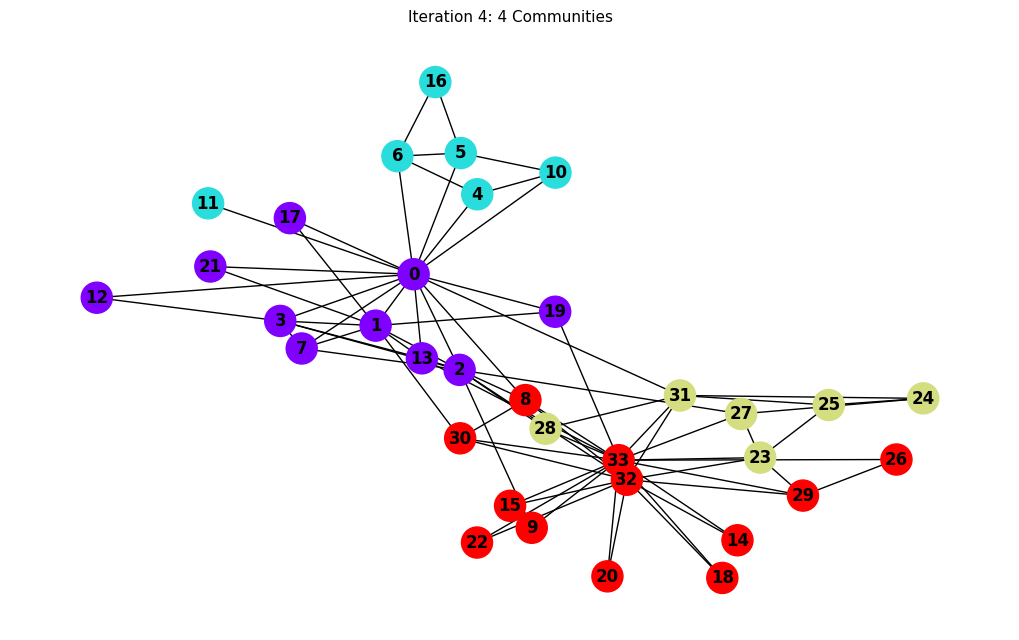

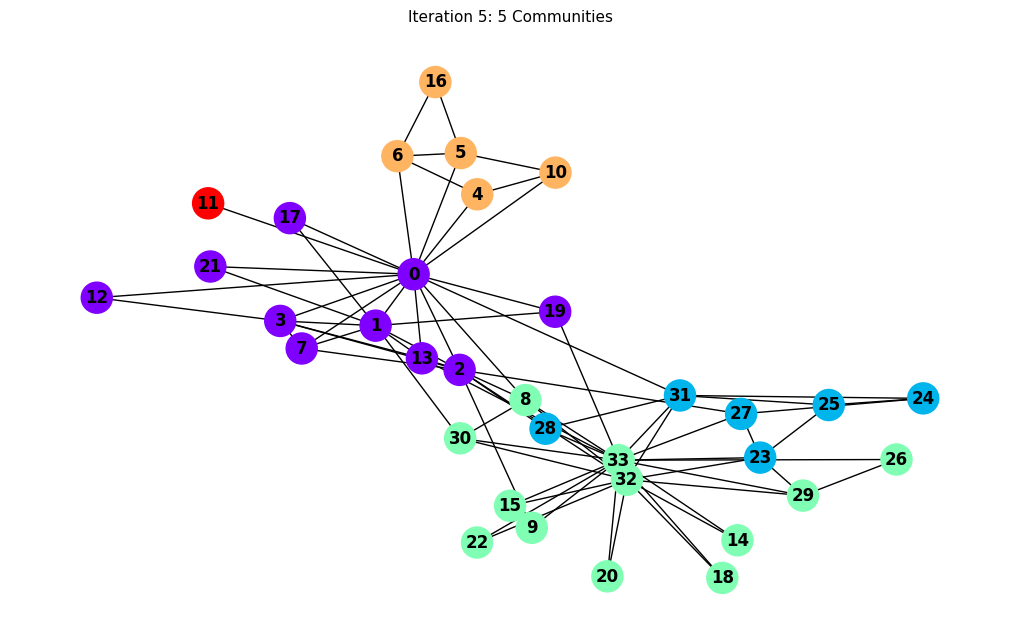

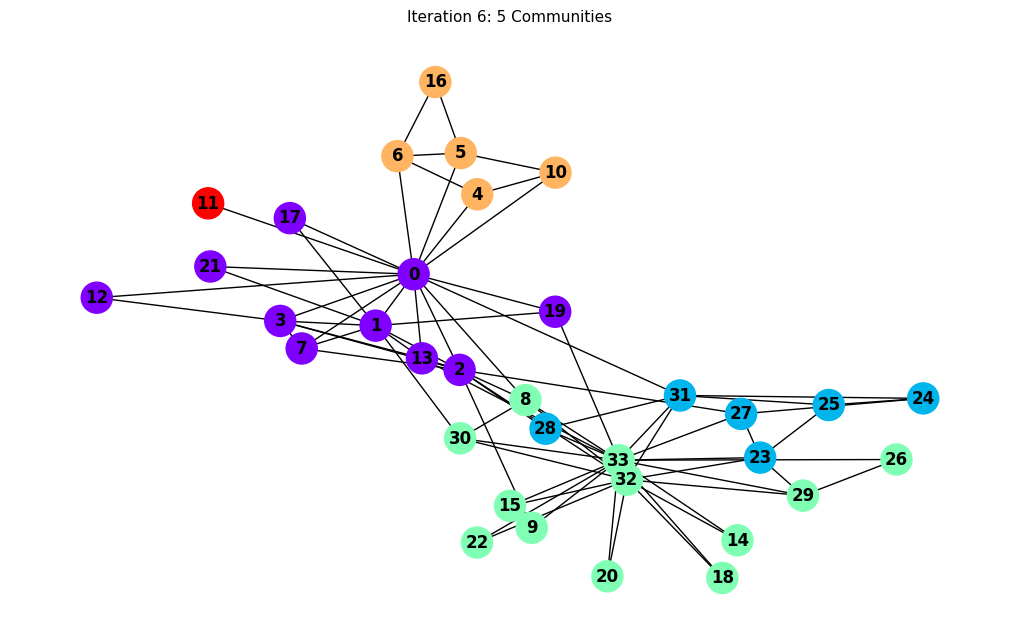

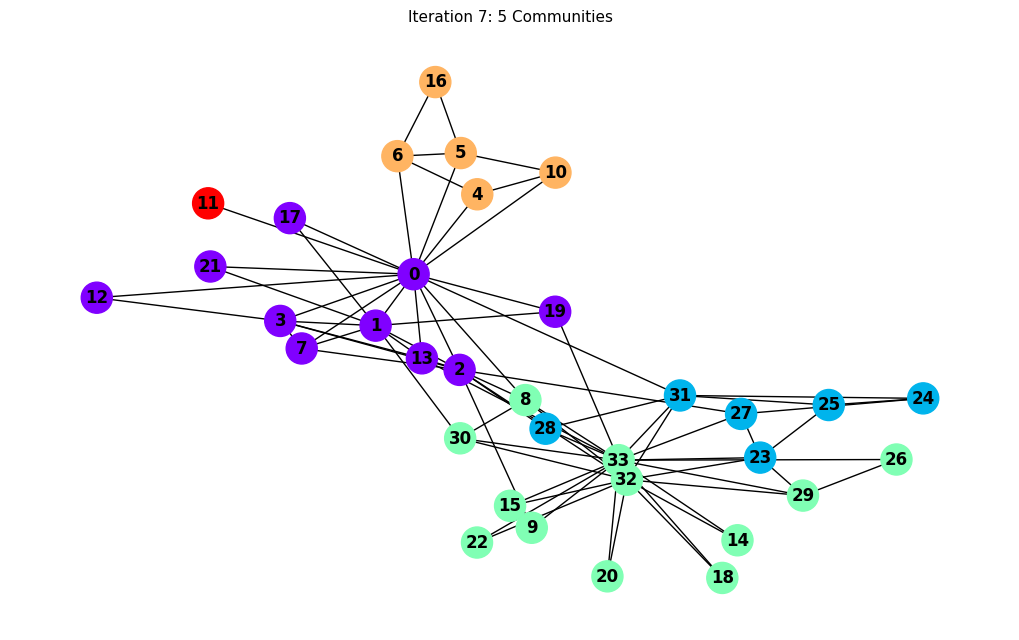

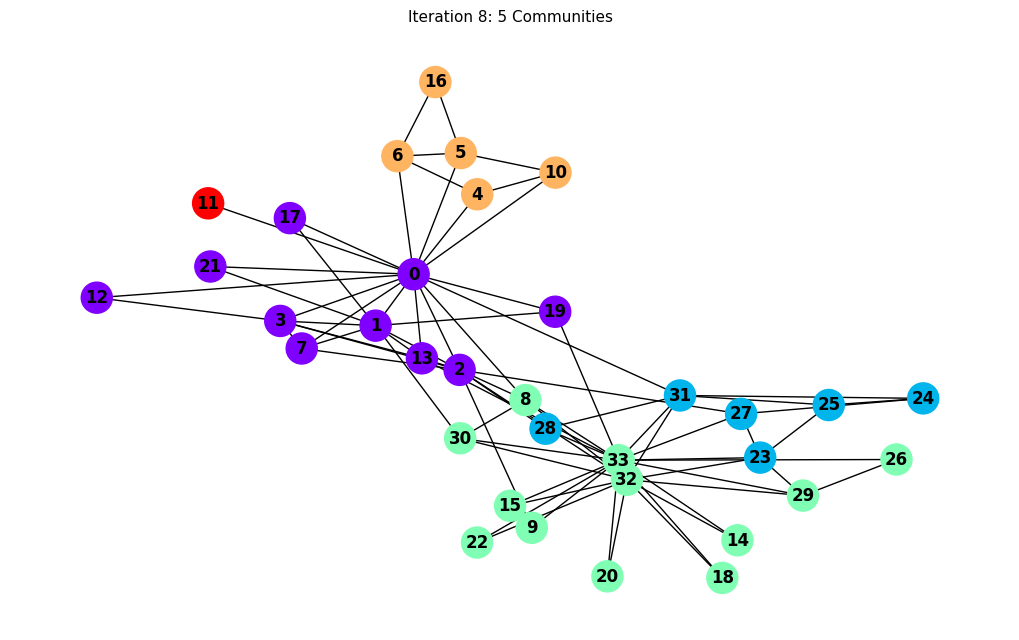

In [6]:
print("--- Visualizing Community Splits ---")

for idx, current_partition in enumerate(partitions_log):
    plt.figure(figsize=(10, 6))

    # Assign colors using the 'rainbow' colormap to match reference style
    node_color_map = {}
    cmap = plt.cm.get_cmap('rainbow', len(current_partition))

    for i, comm in enumerate(current_partition):
        for node in comm:
            node_color_map[node] = cmap(i)

    # Create color list ordered by node ID
    colors_ordered = [node_color_map[n] for n in sorted(G_karate.nodes())]

    # Draw Graph
    nx.draw(
        G_karate,
        layout_pos,
        node_color=colors_ordered,
        with_labels=True,
        node_size=500,
        font_color='black',
        font_weight='bold'
    )

    plt.title(f"Iteration {idx}: {len(current_partition)} Communities", fontsize=11)
    plt.show()

### 5. Metric Evolution Analysis

#### Part A: Data Reshaping
The `metrics_log` is a "list of iterations," where each iteration is a "dictionary of metrics." This is good for logging but difficult to plot.

We must reformat this data into a `metric_plot_data` dictionary, which will be a "dictionary of metrics," where each metric is a "dictionary of nodes," and each node has a "list of values" across iterations.

`metrics_log` -> `[iter_0{...}, iter_1{...}]`
`metric_plot_data` -> `{'degree': {'node_0': [v0, v1], 'node_1': [v0, v1]}, ...}`

In [7]:
# Transform metric data: List of Dicts -> Dict of Lists (per node)
metric_plot_data = {
    m: {n: [] for n in G_karate.nodes()}
    for m in metrics_log[0].keys()
}

total_steps = len(metrics_log)

for i in range(total_steps):
    step_data = metrics_log[i]
    for m_name, node_vals in step_data.items():
        for n, val in node_vals.items():
            metric_plot_data[m_name][n].append(val)

print("Metric data reformatted for plotting.")

Metric data reformatted for plotting.


#### Part B: Plotting Metric Evolution

Now we plot the evolution of each metric. To make the plots clear, we highlight the two main leaders (Node 0, "Mr. Hi," and Node 33, the "Officer") with distinct dashed lines, while all other nodes are plotted faintly in the background. This lets us track the leaders' roles.

--- Plotting Metric Evolution ---
 Below plotted are the graphs for each metric accross each node


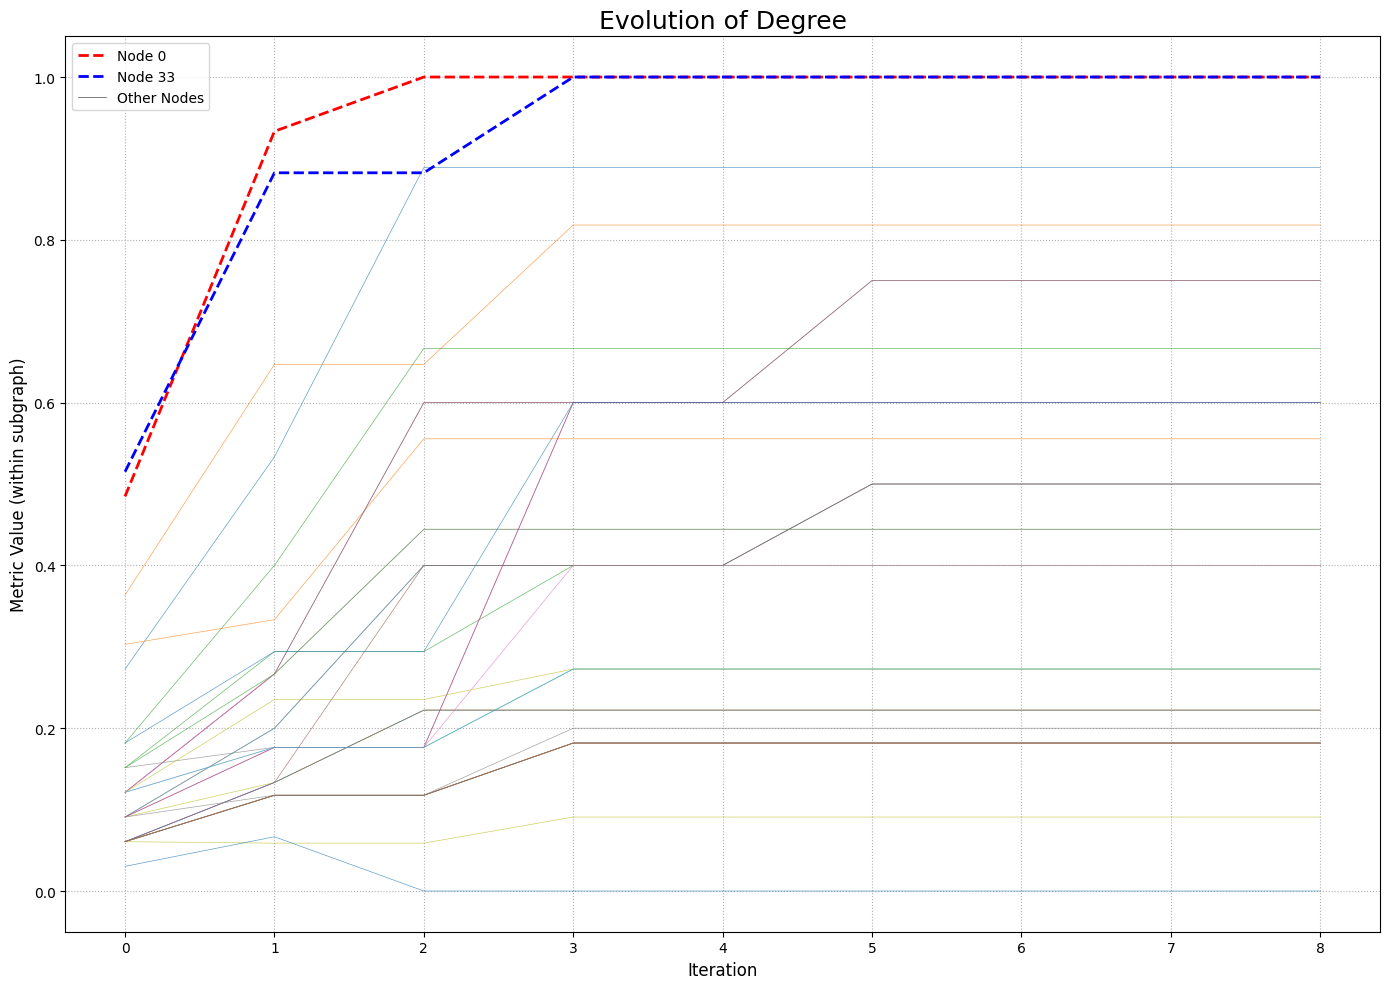

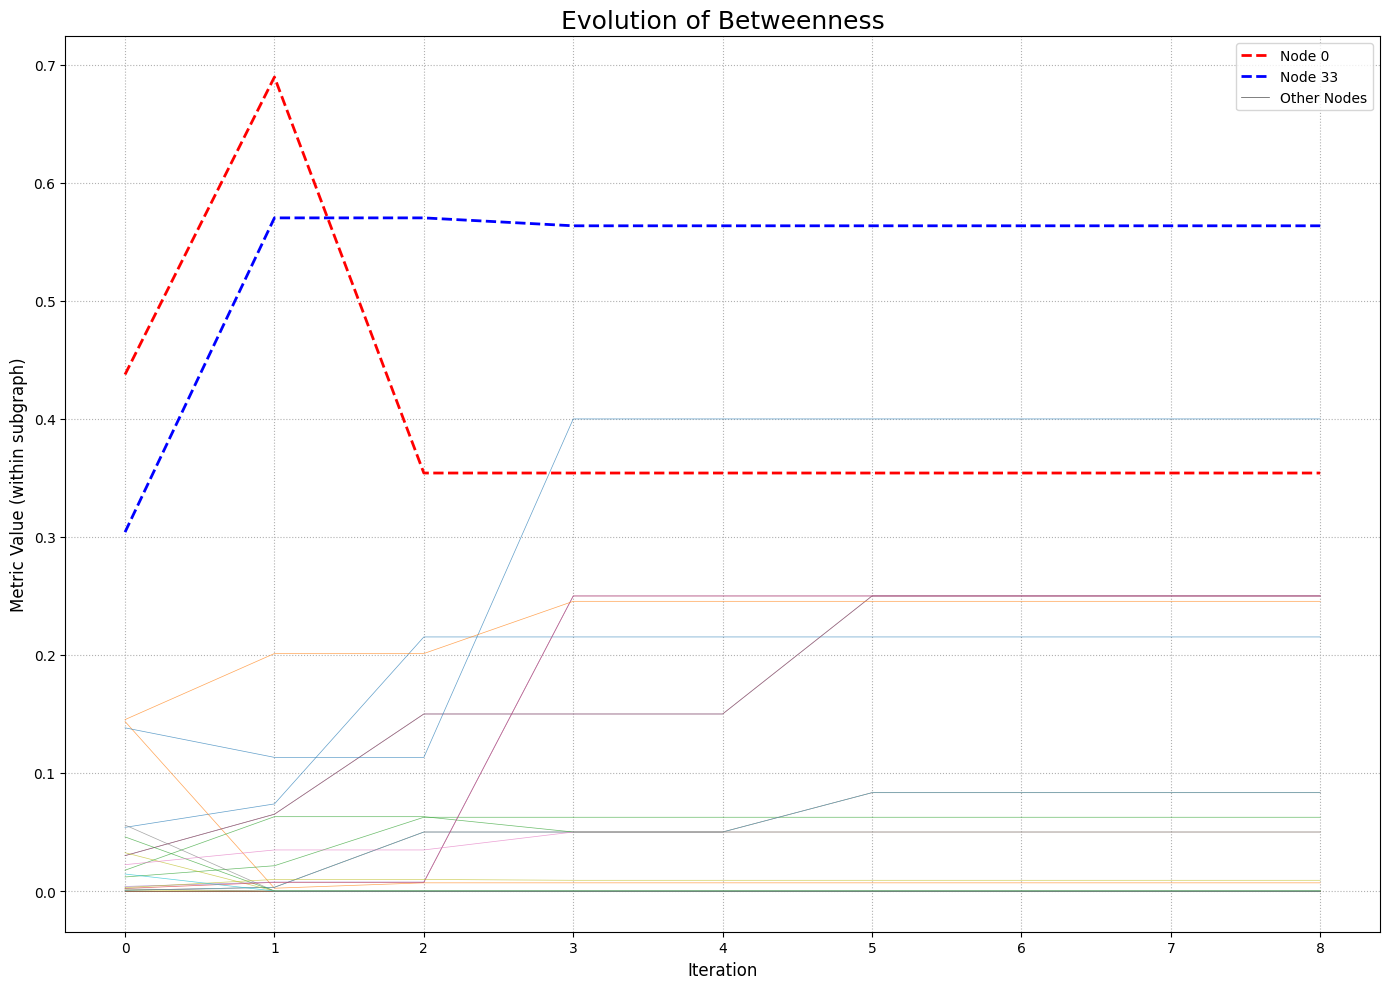

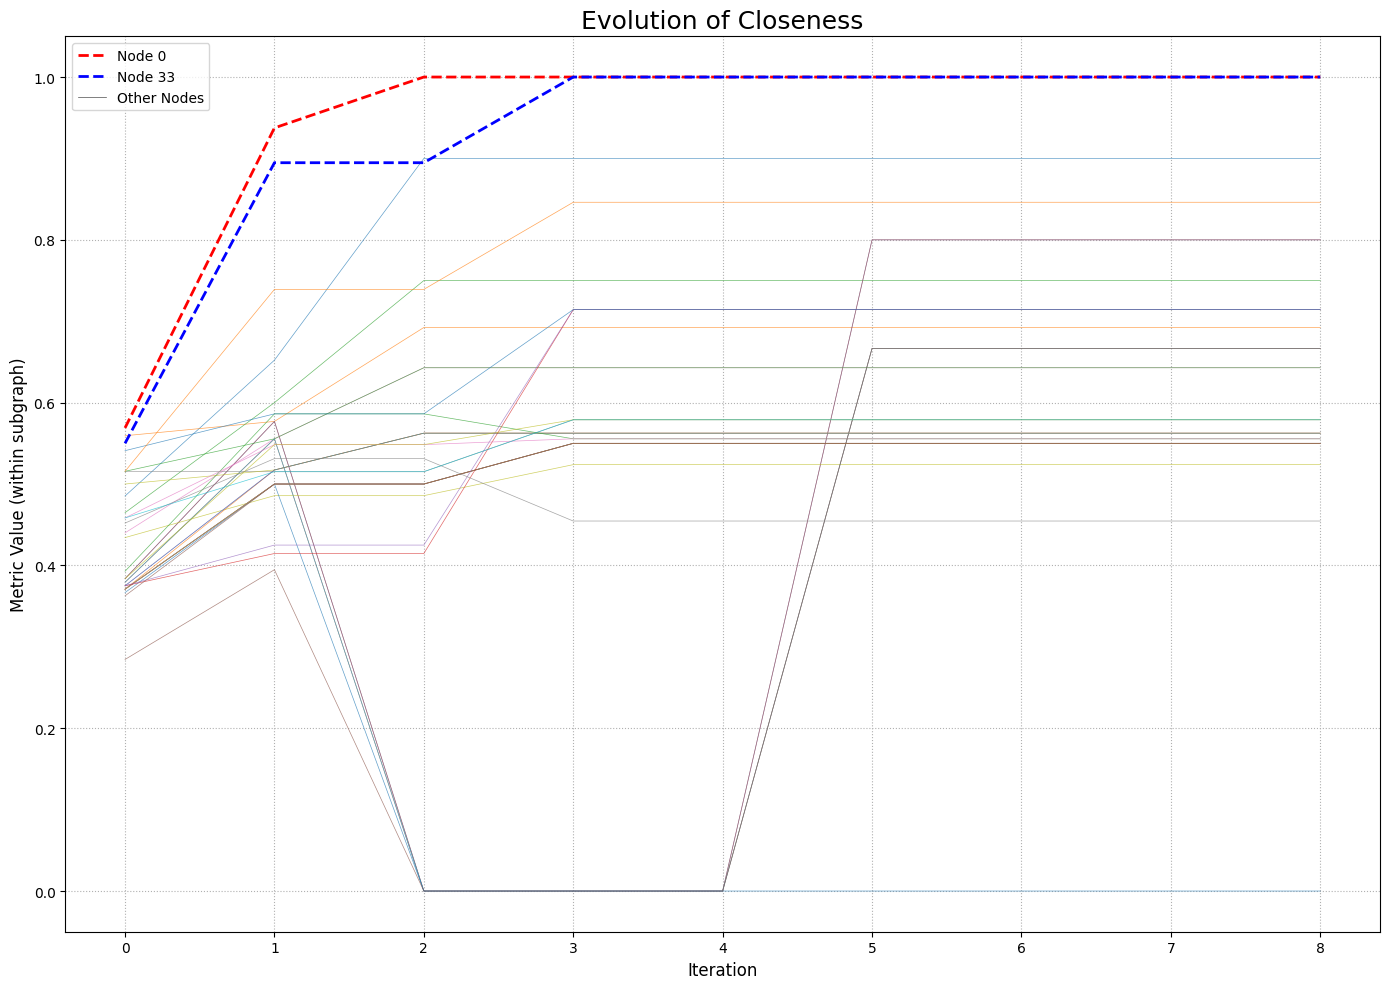

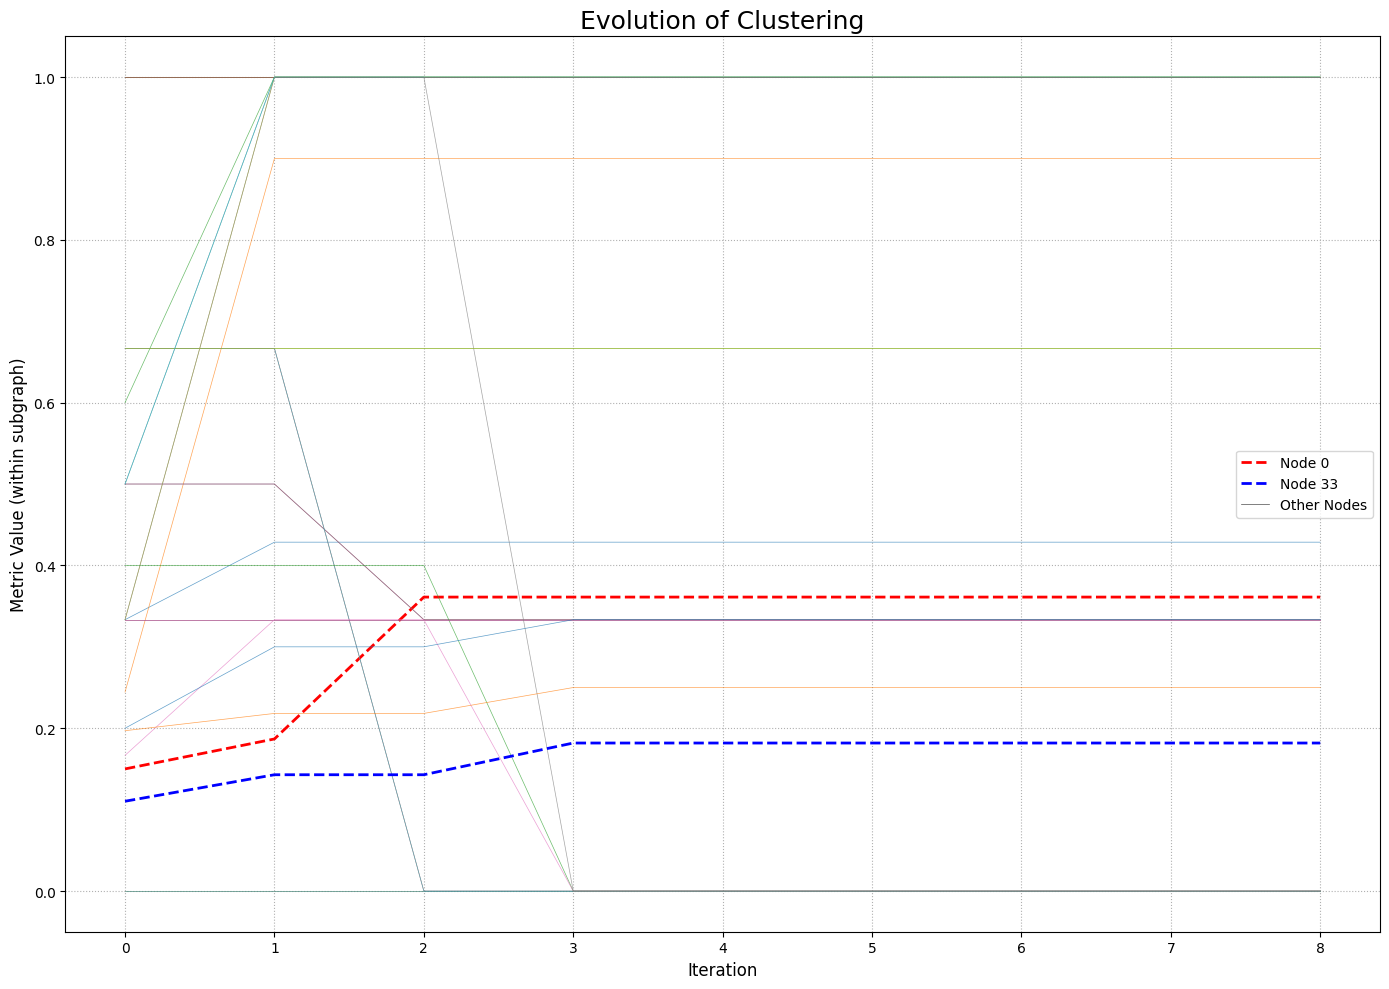

In [8]:
print("--- Plotting Metric Evolution ---")
print(" Below plotted are the graphs for each metric accross each node")

x_ticks = list(range(total_steps))

for metric, data in metric_plot_data.items():
    plt.figure(figsize=(14, 10))

    for node, values in data.items():
        # Special styling for Leaders (Node 0 & 33)
        if node == 0:
            plt.plot(x_ticks, values, label=f"Node {node}",
                     linewidth=2, linestyle='--', color='red')
        elif node == 33:
            plt.plot(x_ticks, values, label=f"Node {node}",
                     linewidth=2, linestyle='--', color='blue')
        else:
            plt.plot(x_ticks, values, label=f"Node {node}",
                     linewidth=0.5, alpha=0.7)

    plt.title(f"Evolution of {metric.title()}", fontsize=18)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("Metric Value (within subgraph)", fontsize=12)
    plt.xticks(x_ticks)
    plt.grid(True, linestyle=':')

    # Custom Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, linestyle='--'),
        Line2D([0], [0], color='blue', lw=2, linestyle='--'),
        Line2D([0], [0], color='black', lw=0.5, alpha=0.7)
    ]
    plt.legend(legend_elements, ['Node 0', 'Node 33', 'Other Nodes'], loc='best')

    plt.tight_layout()
    plt.show()

### 6. Final Summary

Finally, we print a summary of the algorithm's execution and the average metric values for the nodes within each of the final, stable communities.

In [9]:
print("=" * 45)
print("       Final Community & Metric Summary")
print("=" * 45)

# Statistics
splits_done = len(partitions_log) - 1
final_groups = len(final_state)
final_iter_metrics = metrics_log[-1]

print("\n--- Iteration Statistics ---")
print(f"Total Iterations (incl. initial state): {len(partitions_log)}")
print(f"Total Splits Performed:                 {splits_done}")
print(f"Total Final Communities Discovered:   {final_groups}")

print("\n--- Community Details & Final Metrics ---")

for i, comm in enumerate(final_state):
    sorted_comm = sorted(comm)
    print(f"\n  Community {i+1} (Size: {len(sorted_comm)})")
    print(f"    Nodes: {sorted_comm}")
    print("    Average Metrics (within this subgraph):")

    metric_keys = ['degree', 'betweenness', 'closeness', 'clustering']

    for key in metric_keys:
        vals = [final_iter_metrics[key].get(n, 0) for n in comm]

        if vals:
            avg = sum(vals) / len(vals)
        else:
            avg = 0

        print(f"      - Avg. {key.title():<12}: {avg:.4f}")

print("\n" + "=" * 45)

       Final Community & Metric Summary

--- Iteration Statistics ---
Total Iterations (incl. initial state): 9
Total Splits Performed:                 8
Total Final Communities Discovered:   5

--- Community Details & Final Metrics ---

  Community 1 (Size: 10)
    Nodes: [0, 1, 2, 3, 7, 12, 13, 17, 19, 21]
    Average Metrics (within this subgraph):
      - Avg. Degree      : 0.4889
      - Avg. Betweenness : 0.0639
      - Avg. Closeness   : 0.6878
      - Avg. Clustering  : 0.8356

  Community 2 (Size: 6)
    Nodes: [23, 24, 25, 27, 28, 31]
    Average Metrics (within this subgraph):
      - Avg. Degree      : 0.4667
      - Avg. Betweenness : 0.1667
      - Avg. Closeness   : 0.6181
      - Avg. Clustering  : 0.1667

  Community 3 (Size: 12)
    Nodes: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
    Average Metrics (within this subgraph):
      - Avg. Degree      : 0.3182
      - Avg. Betweenness : 0.0682
      - Avg. Closeness   : 0.6172
      - Avg. Clustering  : 0.7582

  Co

### 7. Analysis & Discussion

#### 1. Community Structure
The algorithm successfully identified a hierarchical community structure, breaking the graph down into 5 distinct communities. The splits clearly follow the known social fault lines, with the first major split (Iteration 1) separating the graph into two large factions, one containing Node 0 and the other containing Node 33. The algorithm then recursively found sub-cliques within these main factions.

#### 2. Metric Evolution
The metric plots reveal how a node's "importance" is relative to its community.

The visualization of metric evolution underscores that node 'importance' is contextual rather than absolute. Degree Centrality exhibits a downward trend, confirming its local nature as subgraph sizes diminish. Betweenness Centrality reveals a changing hierarchy; while global leaders (Nodes 0 and 33) initially dominate as network-wide bridges, their influence wanes post-split. Conversely, secondary nodes (such as 2, 8, and 31) experience transient spikes as they assume brokerage roles within their new, smaller sub-communities. Closeness Centrality displays a seemingly counter-intuitive rise; however, this reflects the increased efficiency of traversing smaller, defined communities. Finally, the Clustering Coefficient generally improves, validating the algorithm’s ability to successfully isolate and extract dense, tight-knit cliques from the larger structure.

---
### 3. Conclusion

This project demonstrates that spectral modularity is a powerful unsupervised method for community detection. It not only finds the major "fault lines" in a network but also reveals a deeper, more nuanced structure of sub-communities.

The metric evolution plots prove that a node's "importance" is not static. Instead, a node's role (e.g., as a "broker" vs. a "local leader") is a dynamic property that is entirely defined by the community structure it belongs to at that moment.